# Wikipedia Talk Data - Getting Started

This notebook gives an introduction to working with the various data sets in [Wikipedia
Talk](https://figshare.com/projects/Wikipedia_Talk/16731) project on Figshare. The release includes:

1. a large historical corpus of discussion comments on Wikipedia talk pages
2. a sample of over 100k comments with human labels for whether the comment contains a personal attack
3. a sample of over 100k comments with human labels for whether the comment has aggressive tone

Please refer to our [wiki](https://meta.wikimedia.org/wiki/Research:Detox/Data_Release) for documentation of the schema of each data set and our [research paper](https://arxiv.org/abs/1610.08914) for documentation on the data collection and modeling methodology. 

In this notebook we show how to build a simple classifier for detecting personal attacks and apply the classifier to a random sample of the comment corpus to see whether discussions on user pages have more personal attacks than discussion on article pages.

##  Building a classifier for personal attacks
In this section we will train a simple bag-of-words classifier for personal attacks using the [Wikipedia Talk Labels: Personal Attacks]() data set.

In [1]:
import pandas as pd
import urllib
import unidecode
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics

In [2]:
# download annotated comments and annotations

ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634' 
ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637' 

def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)

# You can edit the code here to download only once, and not download it later                
#download_file(ANNOTATED_COMMENTS_URL, 'attack_annotated_comments.tsv')
#download_file(ANNOTATIONS_URL, 'attack_annotations.tsv')

In [3]:
comments = pd.read_csv('attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('attack_annotations.tsv',  sep = '\t')

In [4]:
len(annotations['rev_id'].unique())

115864

In [5]:
# labels a comment as an attack if the majority of annotators did so
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5

In [6]:
# join labels and comments
comments['attack'] = labels
print(comments.head(10))

                                                  comment  year  logged_in  \
rev_id                                                                       
37675   `-NEWLINE_TOKENThis is not ``creative``.  Thos...  2002      False   
44816   `NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...  2002      False   
49851   NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...  2002      False   
89320    Next, maybe you could work on being less cond...  2002       True   
93890                This page will need disambiguation.   2002       True   
102817  NEWLINE_TOKEN-NEWLINE_TOKENNEWLINE_TOKENImport...  2002       True   
103624  I removed the following:NEWLINE_TOKENNEWLINE_T...  2002       True   
111032  `:If you ever claimed in a Judaic studies prog...  2002       True   
120283  NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENMy apol...  2002       True   
128532  `Someone wrote:NEWLINE_TOKENMore recognizable,...  2002       True   

             ns  sample  split  attack  
rev_id                

## Visualize the data

In [7]:
# Analyze the year
pYear = comments.query('attack').groupby('year').count().reset_index()

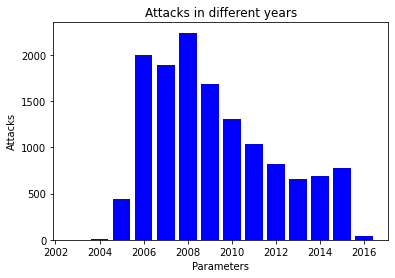

In [8]:
# display a bar chartpYear = comments.query('attack').groupby('year').count().reset_index()
plt.bar("year", "attack", data = pYear, color = "blue")
plt.xlabel("Parameters")
plt.ylabel("Attacks")
plt.title("Attacks in different years")
plt.show()

In [9]:
# Analyze the log_in parameter
pLoggedin = comments.query('attack').groupby('logged_in').count().reset_index()
print(pLoggedin)

   logged_in  comment  year    ns  sample  split  attack
0      False     7635  7635  7635    7635   7635    7635
1       True     5955  5955  5955    5955   5955    5955


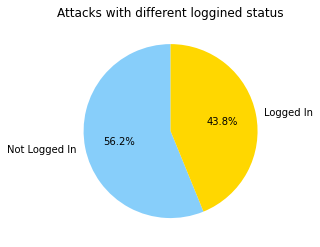

In [10]:
# display a pie chart
labels = ['Not Logged In','Logged In' ]
colors = ['lightskyblue', 'gold']
plt.pie(pLoggedin['attack'], labels= labels, colors=colors, startangle=90, autopct='%.1f%%')
plt.title("Attacks with different loggined status")
plt.show()

In [11]:
# Analyze the ns parameter
pNS = comments.query('attack').groupby('ns').count().reset_index()
print(pNS)

        ns  comment   year  logged_in  sample  split  attack
0  article     2249   2249       2249    2249   2249    2249
1     user    11341  11341      11341   11341  11341   11341


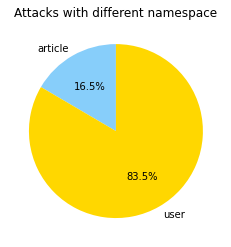

In [12]:
# display a pie chart
labels = ['article', 'user']
colors = ['lightskyblue', 'gold']
plt.pie(pNS['attack'], labels= labels, colors=colors, startangle=90, autopct='%.1f%%')
plt.title("Attacks with different namespace")
plt.show()

# Clean the data

In [13]:
# remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [14]:
# lower and remove non unicode characters
def standardize(text):
    return unidecode.unidecode(text.lower())

comments['comment'] = comments.comment.apply(standardize)

In [15]:
# remove non-alphabetical characters
def remove_non_alpha(text):
    regex = re.compile('[^a-zA-Z\s]')
    return regex.sub('', text)

comments['comment'] = comments.comment.apply(remove_non_alpha)

In [16]:
comments.query('attack').head(10)

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
801279,iraq is not good usa is bad,2003,False,article,random,train,True
2702703,fuck off you little asshole if you want to ...,2004,False,user,random,train,True
4632658,i have a dick its bigger than yours hahaha,2004,False,article,blocked,train,True
6545332,renault you sad little bpy for driving a ...,2004,True,user,blocked,train,True
6545351,renault you sad little bo for driving a r...,2004,True,user,blocked,test,True
7977970,nov utc because you like to accuse me of r...,2004,True,article,random,train,True
8359431,you are not worth the effort you are arguing...,2004,True,user,blocked,train,True
8724028,yes complain to your rabbi and then go shoot s...,2004,True,user,blocked,test,True
8845700,i am using the sandbox ass wipe,2004,False,user,blocked,train,True


In [17]:
comments.query('attack')['comment'].head(10)

rev_id
801279                   iraq is not good      usa is bad   
2702703       fuck off you little asshole if you want to ...
4632658           i have a dick its bigger than yours hahaha
6545332       renault   you sad little bpy for driving a ...
6545351       renault   you sad little bo for driving a r...
7977970      nov  utc  because you like to accuse me of r...
8359431      you are not worth the effort you are arguing...
8724028    yes complain to your rabbi and then go shoot s...
8845700                      i am using the sandbox ass wipe
8845736       god damn   god damn it fuckers i am using t...
Name: comment, dtype: object

## Sample DecsionTree Classifier

In [70]:
# fit a simple text classifier

train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', DecisionTreeClassifier(random_state = 123)),
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])

met = metrics.classification_report(test_comments['attack'], clf.predict(test_comments['comment']))
print(met)

              precision    recall  f1-score   support

       False       0.95      0.95      0.95     20422
        True       0.65      0.62      0.64      2756

    accuracy                           0.92     23178
   macro avg       0.80      0.79      0.79     23178
weighted avg       0.91      0.92      0.91     23178



In [28]:
metirc2 = precision_recall_fscore_support(test_comments['attack'], clf.predict(test_comments['comment']), average='macro')
print(metirc2)

(0.7996659690138055, 0.7893503320858763, 0.7943751638587662, None)


In [20]:
# correctly classify nice comment
clf.predict(['Thanks for you contribution, you did a great job!'])

array([False])

In [21]:
# correctly classify nasty comment
clf.predict(['People as stupid as you should not edit Wikipedia!'])

array([ True])

## Over-sampling Smote

In [89]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import CountVectorizer

train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

X_train=train_comments['comment'].head(14000)
y_train=train_comments['attack'].head(14000)
X_test=test_comments['comment']
y_test=test_comments['attack']

vectorizer1 = CountVectorizer(max_features = 10000, ngram_range = (1,2))
vectorizer1.fit(X_train.values.ravel())
X_train=vectorizer.transform(X_train.values.ravel())
X_test=vectorizer.transform(X_test.values.ravel())
X_train=X_train.toarray()
X_test=X_test.toarray()
print(X_train)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [90]:
sm = SMOTE(random_state=2)
X_res, y_res = sm.fit_resample(X_train, y_train)

## DecisionTree Classifier

In [91]:
clf = DecisionTreeClassifier(random_state = 123).fit(X_res, y_res)

# Return the mean accuracy on the given test data and labels.
clf.score(X_test, y_test)

0.7906204159116403

## GradientBoosting Classifier

In [92]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 max_depth=1, random_state=0).fit(X_res, y_res)
# Return the mean accuracy on the given test data and labels.
clf.score(X_test, y_test)

0.7881611873328156

## LogisticRegression Classifier

In [93]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_res, y_res)
# Return the mean accuracy on the given test data and labels.
clf.score(X_test, y_test)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8478729830011218

## MultinomialNB Classifier

In [96]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_res, y_res)
# Return the mean accuracy on the given test data and labels.
clf.score(X_test, y_test)

0.9163430839589266

## SMV Classifier

In [ ]:
from sklearn.svm import SVC

clf = SVC(kernel='linear', gamma='auto').fit(X_res, y_res)
# Return the mean accuracy on the given test data and labels.
clf.score(X_test, y_test)

## Feature Union

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA, TruncatedSVD
union = FeatureUnion([("pca", PCA(n_components=1)),
                       ("svd", TruncatedSVD(n_components=2)), 
                      ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
                      ('tfidf', TfidfTransformer(norm = 'l2'))])

class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [24]:
class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        return [{'length': len(text),
                 'num_sentences': text.count('.')}
                for text in posts]

In [25]:
train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

pipeline = Pipeline([

    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the year
            ('year', Pipeline([
                ('selector', ItemSelector(key='year')),
                ('tfidf', TfidfVectorizer(min_df=50)),
            ])),

            # Pipeline for standard bag-of-words model for body
            ('comment', Pipeline([
                ('selector', ItemSelector(key='comment')),
                ('tfidf', TfidfVectorizer()),
                ('best', TruncatedSVD(n_components=50)),
            ])),

            # Pipeline for pulling ad hoc features from post's body
            ('namespace', Pipeline([
                ('selector', ItemSelector(key='ns')),
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'year': 0.8,
            'comment': 0.5,
            'namespace': 1.0,
        },
    )),

    # Use a SVC classifier on the combined features
    ('svc', SVC(kernel='linear')),
])
pipeline = pipeline.fit(train_comments, train_comments['attack'])
met = metrics.classification_report(test_comments['attack'], pipeline.predict(test_comments))
print(met)

AttributeError: 'int' object has no attribute 'lower'

## LogisticRegression Classifier

In [20]:
# fit a simple text classifier

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', LogisticRegression(random_state=0)),
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])
met = metrics.classification_report(test_comments['attack'], clf.predict(test_comments['comment']))
print(met)


              precision    recall  f1-score   support

       False       0.94      0.99      0.97     20422
        True       0.92      0.55      0.69      2756

    accuracy                           0.94     23178
   macro avg       0.93      0.77      0.83     23178
weighted avg       0.94      0.94      0.93     23178



In [21]:
metirc2 = precision_recall_fscore_support(test_comments['attack'], clf.predict(test_comments['comment']), average='macro')
print(metirc2)

(0.9306871762038317, 0.772118353538594, 0.8280202850751003, None)


## MultinomialNB Classifier

In [24]:
from sklearn.naive_bayes import MultinomialNB

train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', MultinomialNB()),
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])
met = metrics.classification_report(test_comments['attack'], clf.predict(test_comments['comment']))
print(met)


              precision    recall  f1-score   support

       False       0.94      0.99      0.96     20422
        True       0.88      0.51      0.64      2756

    accuracy                           0.93     23178
   macro avg       0.91      0.75      0.80     23178
weighted avg       0.93      0.93      0.93     23178



In [25]:
metirc3 = precision_recall_fscore_support(test_comments['attack'], clf.predict(test_comments['comment']), average='macro')
print(metirc3)

(0.9081907751028948, 0.7498102625316987, 0.8039775054686669, None)


## SMV Classifier

In [30]:
from sklearn.svm import SVC

train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', SVC(kernel='linear', gamma='auto')),
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])
met = metrics.classification_report(test_comments['attack'], clf.predict(test_comments['comment']))
print(met)

              precision    recall  f1-score   support

       False       0.95      0.99      0.97     20422
        True       0.90      0.60      0.72      2756

    accuracy                           0.94     23178
   macro avg       0.92      0.80      0.84     23178
weighted avg       0.94      0.94      0.94     23178



## Hyperparameters Tuning 

Since Logistice Regress model gives the best result according to the confusion martics, I will continue to optimize the model by using hyperparameters tuning, trying different parameters.

We also use k-fold cross-validation and set k = 2. Therefore, we attempt to maximize the use of the available data for training and then testing a model

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
from sklearn.model_selection import GridSearchCV
pipe = Pipeline([
    ('vect', CountVectorizer(max_features = 10000)),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', LogisticRegression(random_state=0)),
])


In [24]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf__C', 'clf__class_weight', 'clf__dual', 'clf__fit_intercept', 'clf__intercept_scaling', 'clf__l1_ratio', 'clf__max_iter', 'clf__multi_class', 'clf__n_jobs', 'clf__penalty', 'clf__random_state', 'clf__solver', 'clf__tol', 'clf__verbose', 'clf__warm_start'])

In [25]:
# param_grid = dict(estimator__clf__penalty=['l1', 'l2'], estimator__clf__C=[0.5, 1, 5, 10, 50, 100])
param_grid = {'clf__penalty':['l1', 'l2'], 
              'clf__C':[0.5, 1, 5, 10, 50, 100],
              'vect__ngram_range':[(1, 2), (1, 3)]
             }

clf = GridSearchCV(pipe, param_grid, verbose=10, n_jobs=-1, cv=2, return_train_score=False, scoring="accuracy")

clf = clf.fit(train_comments['comment'], train_comments['attack'])
print(clf.cv_results_)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

{'mean_fit_time': array([ 10.13237143,  40.13182962,  11.27746248,  42.53912842,
        14.78471053,  46.31410253,  15.90874791,  59.37552547,
        13.2542491 ,  64.80201411,  17.10616601,  64.42846835,
        17.32607496,  32.8082875 ,  16.92709577,  86.93640447,
        27.47506702, 165.06145144,  56.19363844,  87.60426247,
        27.964908  ,  75.60427296,  24.20180845,  25.07821608]), 'std_fit_time': array([4.72890377e-01, 5.90860844e-03, 4.75875378e-01, 1.73262346e+00,
       1.33623946e+00, 8.98770452e-01, 1.14425111e+00, 4.92912531e-01,
       1.87409019e+00, 5.03989196e+00, 3.31884027e-01, 5.77374697e-02,
       1.72934020e+00, 5.21664035e+00, 9.39029098e-01, 3.45527925e+01,
       7.73879993e+00, 7.69204140e+00, 8.72306764e+00, 1.33573364e+01,
       1.17731202e+00, 4.07794797e+00, 2.56445456e+00, 3.17653894e-01]), 'mean_score_time': array([ 0.        ,  0.        ,  7.14484966, 11.17938173,  0.        ,
        0.        ,  6.65084088, 16.19774902,  0.        ,  0.     

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
clf.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__vect', 'estimator__tfidf', 'estimator__clf', 'estimator__vect__analyzer', 'estimator__vect__binary', 'estimator__vect__decode_error', 'estimator__vect__dtype', 'estimator__vect__encoding', 'estimator__vect__input', 'estimator__vect__lowercase', 'estimator__vect__max_df', 'estimator__vect__max_features', 'estimator__vect__min_df', 'estimator__vect__ngram_range', 'estimator__vect__preprocessor', 'estimator__vect__stop_words', 'estimator__vect__strip_accents', 'estimator__vect__token_pattern', 'estimator__vect__tokenizer', 'estimator__vect__vocabulary', 'estimator__tfidf__norm', 'estimator__tfidf__smooth_idf', 'estimator__tfidf__sublinear_tf', 'estimator__tfidf__use_idf', 'estimator__clf__C', 'estimator__clf__class_weight', 'estimator__clf__dual', 'estimator__clf__fit_intercept', 'estimator__clf__intercept_scaling', 'estimator__clf__l1_ratio', 'estimator__clf__max_iter', 'estimator__

In [28]:
df = pd.DataFrame(clf.cv_results_)
print(df)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_clf__C  \
0       10.132371      0.472890         0.000000        0.000000          0.5   
1       40.131830      0.005909         0.000000        0.000000          0.5   
2       11.277462      0.475875         7.144850        0.384628          0.5   
3       42.539128      1.732623        11.179382        1.098110          0.5   
4       14.784711      1.336239         0.000000        0.000000            1   
5       46.314103      0.898770         0.000000        0.000000            1   
6       15.908748      1.144251         6.650841        0.237424            1   
7       59.375525      0.492913        16.197749        0.779790            1   
8       13.254249      1.874090         0.000000        0.000000            5   
9       64.802014      5.039892         0.000000        0.000000            5   
10      17.106166      0.331884        10.056681        0.265500            5   
11      64.428468      0.057

In [37]:
print(df[['param_vect__ngram_range','param_clf__penalty','param_clf__C', 'param_vect__ngram_range','mean_test_score', 'rank_test_score']])

   param_vect__ngram_range param_clf__penalty param_clf__C  \
0                   (1, 2)                 l1          0.5   
1                   (1, 3)                 l1          0.5   
2                   (1, 2)                 l2          0.5   
3                   (1, 3)                 l2          0.5   
4                   (1, 2)                 l1            1   
5                   (1, 3)                 l1            1   
6                   (1, 2)                 l2            1   
7                   (1, 3)                 l2            1   
8                   (1, 2)                 l1            5   
9                   (1, 3)                 l1            5   
10                  (1, 2)                 l2            5   
11                  (1, 3)                 l2            5   
12                  (1, 2)                 l1           10   
13                  (1, 3)                 l1           10   
14                  (1, 2)                 l2           10   
15      

In [ ]:
print(“Best score: %0.3f” % clf._best_score_)
print(clf._best_params_)

[CV 2/2; 2/24] START clf__C=0.5, clf__penalty=l1, vect__ngram_range=(1, 3)......
[CV 2/2; 2/24] END clf__C=0.5, clf__penalty=l1, vect__ngram_range=(1, 3);, score=nan total time=  42.3s
[CV 2/2; 8/24] START clf__C=1, clf__penalty=l2, vect__ngram_range=(1, 3)........
[CV 2/2; 8/24] END clf__C=1, clf__penalty=l2, vect__ngram_range=(1, 3);, score=0.936 total time=  56.1s
[CV 1/2; 16/24] START clf__C=10, clf__penalty=l2, vect__ngram_range=(1, 3)......
[CV 1/2; 16/24] END clf__C=10, clf__penalty=l2, vect__ngram_range=(1, 3);, score=0.938 total time= 1.4min
[CV 1/2; 23/24] START clf__C=100, clf__penalty=l2, vect__ngram_range=(1, 2).....
[CV 1/2; 23/24] END clf__C=100, clf__penalty=l2, vect__ngram_range=(1, 2);, score=0.927 total time=  27.9s
[CV 2/2; 1/24] START clf__C=0.5, clf__penalty=l1, vect__ngram_range=(1, 2)......
[CV 2/2; 1/24] END clf__C=0.5, clf__penalty=l1, vect__ngram_range=(1, 2);, score=nan total time=  11.9s
[CV 2/2; 5/24] START clf__C=1, clf__penalty=l1, vect__ngram_range=(1, 

## Lessons Learnt

### g. What hyperparameter tuning did you do, and by how many percentage points did your accuracy go up because of hyper-parameter tuning?

I give paramters for the n_gram, clf_penalty, clf_c, and vect_n_gram_range .
And the best result is the n_gram: (1,2), clf_penalty: l2, clf_c: 5, vect_n_gram_range: (1,2) 

### h. What did you learn from the different metrics? How useful was it to use cross-validation?
Different models have different paramterss. We use k-fold cross-validation and set k = 2. Therefore, we attempt to maximize the use of the available data for training and then testing a model

### i. What are your best final Result Metrics? What is the increase in accuracy compared to thestrawman figure? Which model gave you this performance?
LogisticRegression model gave me the best result.
The accuracy improves from 0.91 to 0.94 after the hypermeter tuning

### j. What is the most interesting thing you learned from doing the report?
Oversampling will not necessarily improve the performance of the model

### k. What was the hardest thing to do?
Run the ML model over and over again, and compare the confusion table.

## Prevalence of personal attacks by namespace
In this section we use our classifier in conjunction with the [Wikipedia Talk Corpus](https://figshare.com/articles/Wikipedia_Talk_Corpus/4264973) to see if personal attacks are more common on user talk or article talk page discussions. In our paper we show that the model is not biased by namespace.

In [ ]:
import os
import re
from scipy.stats import bernoulli
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# download and untar data

USER_TALK_CORPUS_2004_URL = 'https://ndownloader.figshare.com/files/6982061'
ARTICLE_TALK_CORPUS_2004_URL = 'https://ndownloader.figshare.com/files/7038050'

download_file(USER_TALK_CORPUS_2004_URL, 'comments_user_2004.tar.gz')
download_file(ARTICLE_TALK_CORPUS_2004_URL,  'comments_article_2004.tar.gz')

os.system('tar -xzf comments_user_2004.tar.gz')
os.system('tar -xzf comments_article_2004.tar.gz')

In [ ]:
# helper for collecting a sample of comments for a given ns and year from 
def load_no_bot_no_admin(ns, year, prob = 0.1):
    
    dfs = []
    
    data_dir = "comments_%s_%d" % (ns, year)
    for _, _, filenames in os.walk(data_dir):
        for filename in filenames:
            if re.match("chunk_\d*.tsv", filename):
                df = pd.read_csv(os.path.join(data_dir, filename), sep = "\t")
                df['include'] = bernoulli.rvs(prob, size=df.shape[0])
                df = df.query("bot == 0 and admin == 0 and include == 1")
                dfs.append(df)
                
    sample = pd.concat(dfs)
    sample['ns'] = ns
    sample['year'] = year
    
    return sample

In [ ]:
# collect a random sample of comments from 2004 for each namespace
corpus_user = load_no_bot_no_admin('user', 2004)
corpus_article = load_no_bot_no_admin('article', 2004)
corpus = pd.concat([corpus_user, corpus_article])

In [ ]:
# Apply model
corpus['comment'] = corpus['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
corpus['comment'] = corpus['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))
corpus['attack'] = clf.predict_proba(corpus['comment'])[:,1] > 0.425 # see paper

In [ ]:
# plot prevalence per ns

sns.pointplot(data = corpus, x = 'ns', y = 'attack')
plt.ylabel("Attack fraction")
plt.xlabel("Dicussion namespace")
plt.show()

Attacks are far more prevalent in the user talk namespace.